<a href="https://colab.research.google.com/github/LANZhengyang/Bayesian-Learning-via-SGLD/blob/main/notebook/2D_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import math


## Introduction
This notebook will show the implementation of Stochastic Gradient Langevin Dynamics on estimatation of mean of 2D normal distribution.

## Display the true distribution
Use very large sample size to make it approach to true distribution.

Text(0.5, 0.98, 'True distribution')

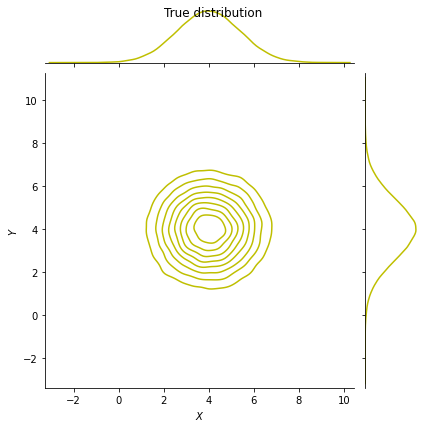

In [ ]:
N = 100000

# sample theta 
theta_train = torch.distributions.multivariate_normal.MultivariateNormal(4*torch.ones(2), torch.eye(2))
data_theta_train = theta_train.sample(sample_shape=torch.Size([N]))
data_train = []

#sample X
for i in range(N):
    m=torch.distributions.multivariate_normal.MultivariateNormal(data_theta_train[i], torch.eye(2))
    data_train.append(m.sample().numpy())
    
df_train = pd.DataFrame(np.array(data_train), columns=["x", "y"])

#plot distribution of X
g = sns.jointplot(x="x", y="y", data=df_train, kind="kde", color="y")
g.ax_joint.collections[0].set_alpha(0)  
g.set_axis_labels("$X$", "$Y$")
g.fig.suptitle("True distribution")

## Sample train data and display trainset distribution
Use smaller sample size to let the model easier to be overfitting.

Text(0.5, 0.98, 'Trainset distribution')

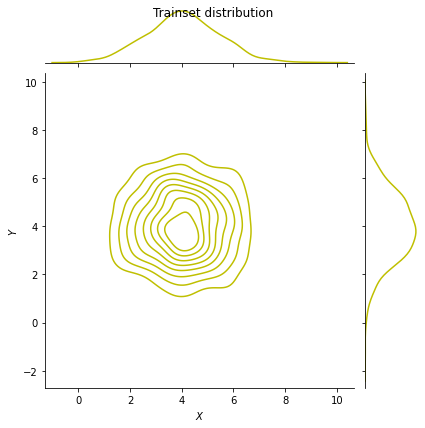

In [ ]:
# sample trainset

N = 1000
theta_train = torch.distributions.multivariate_normal.MultivariateNormal(4*torch.ones(2), torch.eye(2))
data_theta_train = theta_train.sample(sample_shape=torch.Size([N]))
data_train = []

for i in range(N):
    m=torch.distributions.multivariate_normal.MultivariateNormal(data_theta_train[i], torch.eye(2))
    data_train.append(m.sample().numpy())
    
df_train = pd.DataFrame(np.array(data_train), columns=["x", "y"])

# display sample distribution
g = sns.jointplot(x="x", y="y", data=df_train, kind="kde", color="y")
g.ax_joint.collections[0].set_alpha(0)  
g.set_axis_labels("$X$", "$Y$")
g.fig.suptitle("Trainset distribution")

## Start Stochastic Gradient Langevin Dynamics and display the sample distribution

tensor([-0.7354,  0.6990], requires_grad=True)
0 0.001 tensor([-0.7354,  0.6990], requires_grad=True)
400 3.700586797407731e-05 tensor([4.0531, 4.0159], requires_grad=True)
800 2.5293103207940207e-05 tensor([4.0474, 4.0159], requires_grad=True)
1200 2.0241903305642964e-05 tensor([4.0325, 4.0229], requires_grad=True)
1600 1.7281632578471283e-05 tensor([4.0384, 4.0112], requires_grad=True)
2000 1.528671262150443e-05 tensor([4.0514, 3.9905], requires_grad=True)
2400 1.3828794151030219e-05 tensor([4.0422, 4.0233], requires_grad=True)
2800 1.2705091296132364e-05 tensor([4.0374, 4.0114], requires_grad=True)
3200 1.180573088742481e-05 tensor([4.0490, 4.0141], requires_grad=True)
3600 1.1065404217058437e-05 tensor([4.0249, 4.0145], requires_grad=True)
4000 1.044256763338291e-05 tensor([4.0416, 4.0110], requires_grad=True)
4400 9.909386034010592e-06 tensor([4.0486, 4.0093], requires_grad=True)
4800 9.446426759291724e-06 tensor([4.0458, 4.0076], requires_grad=True)
5200 9.039662796235096e-06 ten

Text(0.5, 1.0, 'Sample distribution')

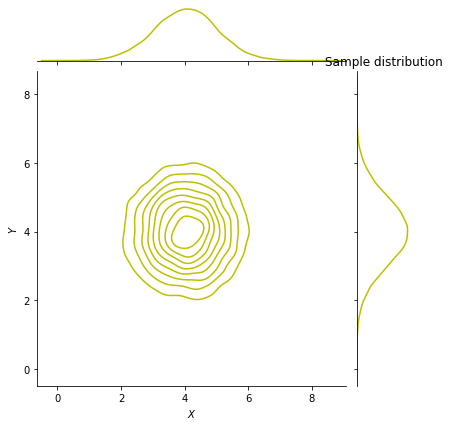

In [ ]:
para = torch.randn((2), requires_grad=True)
print(para)

#decay parameter of learning rate
a=0.001
b=1
gamma=0.55

data_hat = []  # sample list

injected_noise_v = [] # list of variance of injected noise

n=batch_size = 100

Vs0= [] # empirical covariance theta1 list
Vs1= [] # empirical covariance theta2 list
Vs = [] # empirical covariance list

for t in range(20000):
    
    # update learning rate/ step size
    learning_rate = a *(b+t)**(-gamma)
    
    if t % 400 == 0:
        print(t,learning_rate,para)

    # select data from all data
    sample_index = torch.randperm(N)[:batch_size]
    batch = torch.tensor(data_train)[sample_index]
    
    pos=torch.distributions.multivariate_normal.MultivariateNormal(para, torch.eye(2))  # posterior
    p=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2)) # proir
    
    (p.log_prob(para)+(N/batch_size)*sum(pos.log_prob(batch))).backward()

    # updata parameter
    with torch.no_grad():
        
        
        para += (learning_rate/2) * (para.grad) + torch.distributions.normal.Normal(0,learning_rate).sample(sample_shape=torch.Size([2]))

        # Manually zero the gradients after updating weights
        para.grad = None


    # start sample when the injected noise is bigger than SG noise 
    if t>100:
        m_hat=torch.distributions.multivariate_normal.MultivariateNormal(para, torch.eye(2))
        data_hat.append(m_hat.sample().numpy())
        
    
    # save Vs and learning rate  
    
    injected_noise_v.append(learning_rate)
    st = []
    for i in range(len(batch)):
        ((1/N)*p.log_prob(para)+(pos.log_prob(batch[i]))).backward()
        with torch.no_grad():
        
            st.append((para.grad.numpy()))
            para.grad = None
        
    Vs0.append(np.var(np.array(st)[:,0]))
    Vs1.append(np.var(np.array(st)[:,1]))
    Vs.append(np.var(np.array(st)))
    
df_hat = pd.DataFrame(np.array(data_hat), columns=["x", "y"])

g = sns.jointplot(x="x", y="y", data=df_hat, kind="kde", color="y")
g.ax_joint.collections[0].set_alpha(0)  
g.set_axis_labels("$X$", "$Y$")
plt.title("Sample distribution")


- We can find that even the train data is not follow the true distribution well, but there is no much overfitting of sample on the train set.

## Compare Variance of SG noise and injected noise

Text(0.5, 1.0, 'Evolution of distribution of sample')

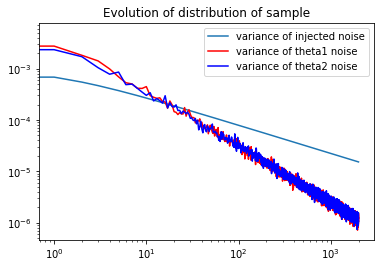

In [ ]:
plt.plot(range(len(injected_noise_v)),(injected_noise_v),label='variance of injected noise')
plt.xscale("log")
plt.yscale("log")

plt.plot(np.array(N**2/n)*Vs0*(np.array(injected_noise_v)/2)**2,c='r',label="variance of theta1 noise ")
plt.plot(np.array(N**2/n)*Vs1*(np.array(injected_noise_v)/2)**2,c='b',label="variance of theta2 noise")
plt.legend()
plt.title('Evolution of distribution of sample')

- In the paper, the author's Figure 2 does not fixed learning rate, so I just do mine like paper. It also got very good results